In [71]:
%pylab inline
%load_ext autoreload
%autoreload 2
import geopandas as gpd
import networkx as nx
import pyriv
from pyriv import rg_light as rgl
import os
import mplleaflet

data_dir = '/home/shares/scientist/pyriv/shapefiles/'
fp = lambda s: os.path.join(data_dir, s)

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Distance Calculations

Now that the river network and full network [have been generated](NetworkGeneration.ipynb), we can load those networks and calculate distances. We'll calculate distance to ocean for each point first. Then we'll calculate a minimum aquatic distance (MAD) distance matrix for a set of points. We'll start off with a test set of 4 locations to make things simple.

## Test Sites

I'll load the ASL sites and choose 4 to work with.

In [157]:
asl_locs = gpd.read_file(fp("sasap_asl_locations.shp")).to_crs(epsg=3338)
test_sites = ["Takotna River", "Bearfeed Creek", "Tuya River", "Gisasa River",
              "Chulitna River","Tanada Creek"]
sites = asl_locs.query("LoctnID in @test_sites").copy()
sites['label'] = sites.LoctnID.apply(lambda s: s.split(" ")[0])
sites.to_file(fp("output/sasap_test_sites.shp"))
sites

,LoctnID,LctnUnq,geometry,label
123,Tanada Creek,Tanada Creek-escapement-21220,POINT (521292.5934848016 1444835.709979868),Tanada
224,Takotna River,Takotna River-escapement-NA,POINT (-88075.8837163798 1454626.831818744),Takotna
579,Tuya River,Tuya River-escapement-10840,POINT (1334601.614419002 1163623.253109731),Tuya
672,Gisasa River,Gisasa River-escapement-33446,POINT (-175364.8413639127 1702454.903710796),Gisasa
689,Bearfeed Creek,Bearfeed Creek-escapement-NA,POINT (969395.1024302522 1493303.242275307),Bearfeed
697,Chulitna River,Chulitna River-escapement-NA,POINT (-31296.31700738975 1132722.828032746),Chulitna


Load the land shapefile.

In [140]:
lndfn = fp('SASAP_coast_poly1000m.shp')
lnddf = gpd.read_file(lndfn)

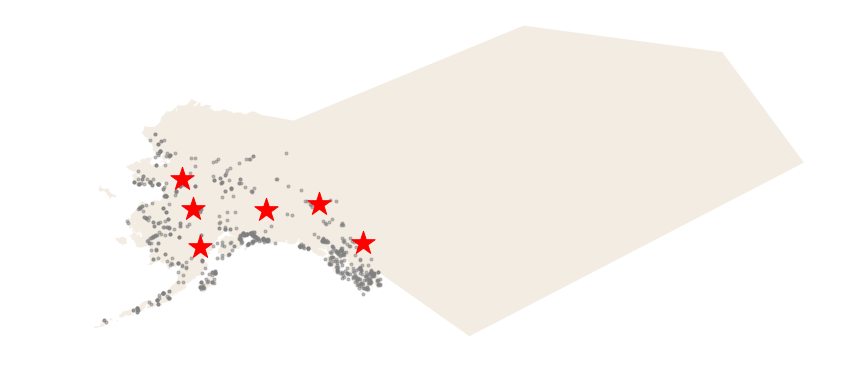

In [145]:
figsize(14,10)
ax = asl_locs.plot(c='gray', alpha=0.5, marker='.')
ax = sites.plot(c='r', marker='*', markersize=600, ax=ax)
ax = lnddf.plot(ax=ax, zorder=0, alpha=0.25, color='tan')
ax.set_axis_off()

The red stars are the test sites. The grey dots are the other ASL sites. The background land polygon includes a large mask area over Canada to make sure no paths get routed across land.

## Load Networks

First, I'll load the pickled full river graph and turn it into a `RiverGraph` object.

In [60]:
%%time
rivgrnx = nx.read_gpickle(fp('output/full_rgr.gpickle'))
rivgr = rgl.RiverGraph(data=rivgrnx, coastline=lnddf)

CPU times: user 15.7 s, sys: 4.6 s, total: 20.3 s
Wall time: 20.8 s


Then I'll load the full (river + coastal) graph.

In [58]:
%%time
full_graph = nx.read_gpickle(fp('output/total_connected.gpickle'))

CPU times: user 11.4 s, sys: 4.06 s, total: 15.5 s
Wall time: 15.5 s


## River Distances

In [63]:
from pyriv import point_processor as pp

In [146]:
%%time
rivdist = pp.river_distances(sites, rivgr, node_distance=True)

CPU times: user 6.21 s, sys: 140 ms, total: 6.35 s
Wall time: 6.34 s


In [158]:
rivdist.drop(["geometry","nearest_node","path","LctnUnq"], axis="columns")

,LoctnID,label,rivdist_km,node_dist
123,Tanada Creek,Tanada,383.954367,481.507788
224,Takotna River,Takotna,735.768341,205.674382
579,Tuya River,Tuya,292.716932,2182.945590
672,Gisasa River,Gisasa,880.391142,106.512303
689,Bearfeed Creek,Bearfeed,2694.971429,334.875949
697,Chulitna River,Chulitna,227.518956,37.110620


We've now got distance to the ocean in km (`rivdist_km`). The `node_dist` column gives us the distance (in meters) from the site to the closest network node. Basically the closest spot on a river that counts as the start or end of a hydrographic 'reach'. Values in the hundreds of meters are to be expected. Depending on how precise you want to be, values more than a km or 2 may warrant looking into.

In [155]:
pthout = rivdist.set_geometry("path").drop(["geometry","nearest_node"], axis="columns")
pthout.to_file(fp("output/sasap_river_paths.shp"))

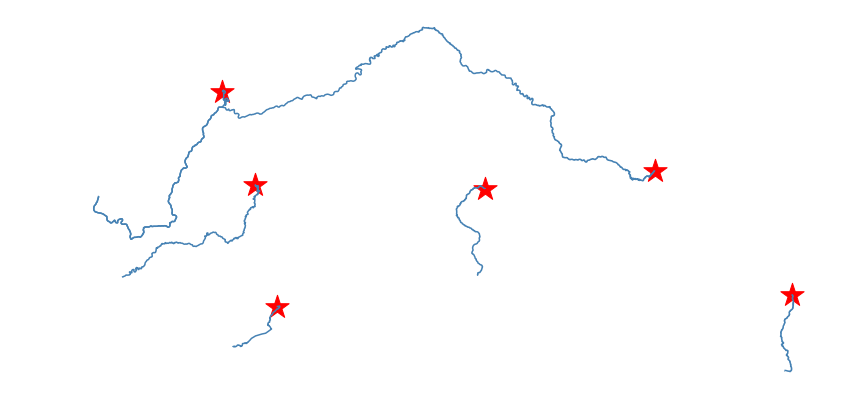

In [169]:
figsize(14,10)
ax = rivdist.set_geometry("path").plot(color="steelblue")
ax = sites.plot(c='r', marker='*', markersize=600, ax=ax)
# ax = lnddf.plot(ax=ax, zorder=0, alpha=0.25, color='tan')
ax.set_axis_off()
## if you want a nice slippy map, uncomment this next line
## ...but it makes the .ipynb file quite large so I don't
## like to check notebooks into the repo with leaflet maps
# mplleaflet.display(epsg=3338)

Some paths may not appear to reach the coast on first glance. That's okay. The coastline polygon being used here is based on a hydrographic dataset (described a bit more [here](NetworkGeneration.ipynb)) that tends to make the distinction between river mouth and ocean quite far up the estuary. Basically, if you zoom in far enough with this in mind, you'll generally find that it does look like it's a reasonable location for the river mouth.

## MAD Matrix

In [149]:
from pyriv.coastal import mad_df, mad_matrix

In [150]:
%%time
maddf = mad_df(full_graph, sites, "label")

CPU times: user 4min 29s, sys: 24.8 s, total: 4min 54s
Wall time: 4min 51s


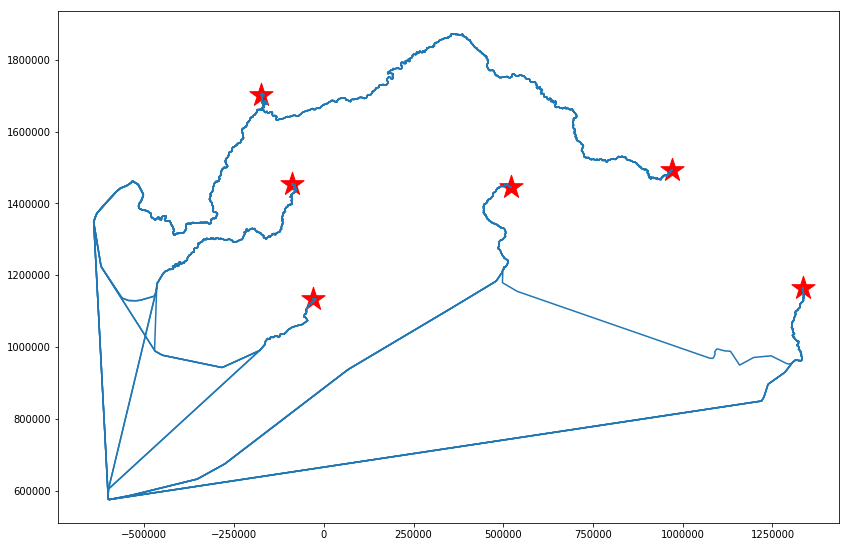

In [170]:
ax = sites.plot(c='r', marker='*', markersize=600)
ax = maddf.plot(ax = ax)
## Uncomment for slippy map
# mplleaflet.display(epsg=3338)

Save out the paths to a shapefile and view the tabular results in long form.

In [171]:
maddf.to_file(fp("output/sasap_mad_paths.shp"))
maddf.drop(["geometry"], axis="columns")

,from,to,failure_flag,dist_km
0,Tanada,Takotna,0,3071.283990
1,Tanada,Tuya,0,1621.337393
2,Tanada,Gisasa,0,3541.043365
3,Tanada,Bearfeed,0,5355.623652
4,Tanada,Chulitna,0,2558.455522
5,Takotna,Tuya,0,3679.923587
6,Takotna,Gisasa,0,2228.534634
7,Takotna,Bearfeed,0,4043.114922
8,Takotna,Chulitna,0,1556.527309
9,Tuya,Gisasa,0,4149.682962


Convert the results to a distance matrix in pandas dataframe format.

In [153]:
madmat = mad_matrix(maddf)

In [154]:
madmat.round().astype('int')

,Bearfeed,Chulitna,Gisasa,Takotna,Tanada,Tuya
Bearfeed,0,3901,2041,4043,5356,5964
Chulitna,3901,0,2086,1557,2558,3167
Gisasa,2041,2086,0,2229,3541,4150
Takotna,4043,1557,2229,0,3071,3680
Tanada,5356,2558,3541,3071,0,1621
Tuya,5964,3167,4150,3680,1621,0
